In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from hyperopt import hp

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


# XGB regression tuning

In [2]:
data, y = make_regression(
    n_samples=1000, n_features=10, n_informative=5, noise=20)
data = pd.DataFrame(data=data, columns=['f'+str(i+1) for i in range(data.shape[1])])
# Make data positive, add some non-linearity and 5% of outliers.
y = (y + abs(y.min())) ** 2
y[np.random.choice(range(len(y)), int(len(y)*0.05))] += y.max()
y /= 1000

features = [c for c in data.columns]
train, test, ytrain, ytest = train_test_split(data[features], y, test_size=0.25)

scaler = StandardScaler()
train = pd.DataFrame(data=scaler.fit_transform(train),  columns=features)
test  = pd.DataFrame(data=scaler.transform(test),  columns=features)

In [3]:
# Define parameters space for hyperopt to search.
base_params = {
    'objective': 'reg:linear',
    'eval_metric': 'rmse', 
    'booster': 'gbtree',
    'tree_method':'hist',
    'learning_rate': 0.05
}

tunable_params = {
    'max_depth'         :hp.quniform('max_depth',   2, 12, 1),

    'colsample_bytree'  :hp.uniform ('colsample_bytree', 0.5, 1),
    'colsample_bylevel' :hp.uniform ('colsample_bylevel',0.5, 1),
    
    'max_bin'           :hp.loguniform('max_bin', log(2), log(500)),
    'min_child_weight'  :hp.loguniform('min_child_weight', log(1e-3), log(len(train)/10)),
    'gamma'             :hp.loguniform('gamma',  log(1e-3), log(30)),
    'alpha'             :hp.loguniform('alpha',  log(1e-3), log(30)),
    'lambda'            :hp.loguniform('lambda', log(1e-3), log(30))
}
# Hyperopt returns params in float form, which is
# unacceptable for some parameters of model.
# integer_params will be transformed to ints.
integer_params = ['max_depth', 'max_bin']

In [4]:
from tuner import Tuner
T = Tuner(
    train=train, ytrain=ytrain,
    model='xgb', maximize=False,
    base_params=base_params,
    tunable_params=tunable_params,
    integer_params=integer_params,
    n_splits=3, stratify=False, split_seed=0 
)

Started 1 epoch of tuning
Default parameters score for current folds: 155.7015
50 trials are done in 4.9 minutes. Best metric achieved is 150.7192

Started 2 epoch of tuning
Default parameters score for current folds: 166.9477
15 trials are done in 0.3 minutes. Best metric achieved is 152.1037

Started 3 epoch of tuning
Default parameters score for current folds: 160.9265
5 trials are done in 0.1 minutes. Best metric achieved is 149.709



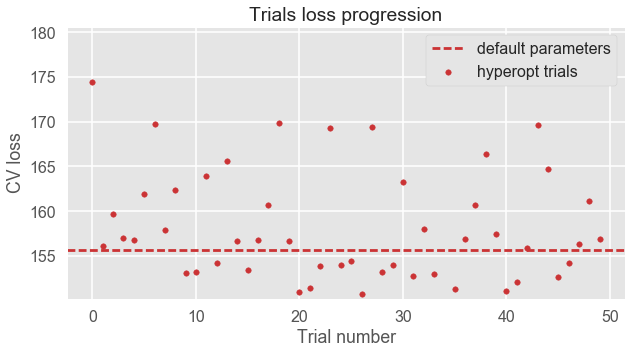

,params,num_iters,checks,total_loss,1_epoch_loss,2_epoch_loss,3_epoch_loss
0,"{'gamma': 13.29605083326353, 'eval_metric': 'r...",191,3,452.531993,150.719249,152.103699,149.709045
1,"{'gamma': 19.854244604819474, 'eval_metric': '...",157,3,454.152969,151.412664,152.866658,149.873647
2,"{'gamma': 26.590269014438505, 'eval_metric': '...",147,3,454.572870,151.269023,153.362594,149.941253
3,"{'gamma': 16.766378338052316, 'eval_metric': '...",134,3,455.668635,150.941157,154.085851,150.641627
4,"{'gamma': 13.68480717990419, 'eval_metric': 'r...",114,3,456.834396,151.037069,154.035624,151.761704


In [5]:
T.tune(trials_to_to=[50, 15, 5])
T.plot_1_epoch_results()
T.results.head()

In [6]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

model = xgb.train(
    T.results.sort_values('1_epoch_loss').iloc[0].params,
    xgb.DMatrix(train, ytrain),
    num_boost_round=T.results.sort_values('1_epoch_loss').iloc[0].num_iters)
print('Best model after first epoch on test:',
      mean_squared_error(ytest, model.predict(xgb.DMatrix(test))))

model = xgb.train(
    T.results.iloc[0].params,
    xgb.DMatrix(train, ytrain),
    num_boost_round=T.results.iloc[0].num_iters)
print('Best model after all epochs on test:',
      mean_squared_error(ytest, model.predict(xgb.DMatrix(test))))

print('\nBest parameters:')
print(T.results.iloc[0].params)
print('\nNumber of trees for these parameters:', T.results.iloc[0].num_iters)

Best model after first epoch on test: 31397.086014
Best model after all epochs on test: 31397.086014

Best parameters:
{'gamma': 13.29605083326353, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'alpha': 0.054060583031301485, 'max_depth': 2, 'max_bin': 13, 'booster': 'gbtree', 'min_child_weight': 0.0010179367081882226, 'learning_rate': 0.05, 'tree_method': 'hist', 'colsample_bytree': 0.5455501384423267, 'lambda': 14.198764991079345, 'colsample_bylevel': 0.6427698270371859}

Number of trees for these parameters: 191


# LGB multiclass classification tuning

In [7]:
data, y = make_classification(
    n_classes=5, n_samples=5000, n_features=10, n_informative=5, n_redundant=2, flip_y=0.05)
data = pd.DataFrame(data=data, columns=['f'+str(i+1) for i in range(data.shape[1])])

features = list(data.columns)
train, test, ytrain, ytest = train_test_split(data, y, test_size=0.25)

scaler = StandardScaler()
train = pd.DataFrame(data=scaler.fit_transform(train),  columns=features)
test  = pd.DataFrame(data=scaler.transform(test),  columns=features)

In [8]:
# Define parameters space for hyperopt to search 
base_params = {
    'metric': 'multi_logloss',
    'objective': 'multiclass',
    'learning_rate' : 0.05,
    'num_class': len(np.unique(y))
}

tunable_params = {
    'num_leaves'        :hp.loguniform('num_leaves',  log(2), log(2**12)),
    'max_bin'           :hp.loguniform('max_bin', log(2), log(500)),
    #'scale_pos_weight'  :hp.uniform ('scale_pos_weight', 1, 20),
    
    'min_data_in_leaf'  :hp.loguniform('min_data_in_leaf', log(1e-3), log(len(train)/10)),
    'min_split_gain'    :hp.loguniform('min_split_gain',  log(1e-3), log(len(train)/10)),
    'lambda_l2'         :hp.loguniform('lambda_l2',  log(1e-3), log(10)),
    'lambda_l1'         :hp.loguniform('lambda_l1', log(1e-3), log(10)),
    
    'feature_fraction'  :hp.uniform ('feature_fraction', 0.5, 1),
    'bagging_fraction'  :hp.uniform ('bagging_fraction', 0.5, 1),
    'bagging_freq'      :hp.uniform('bagging_freq', 0, 10)
}

# Hyperopt returns params in float form, which is
# unacceptable for some parameters of model.
# integer_params will be transformed to ints.
integer_params = ['max_depth', 'max_bin', 'num_leaves', 'min_data_in_leaf', 'bagging_freq']

In [9]:
from tuner import Tuner
T = Tuner(
    train=train, ytrain=ytrain,
    model='lgb', maximize=False,
    base_params=base_params,
    tunable_params=tunable_params,
    integer_params=integer_params,
    n_splits=3, split_seed=0, stratify=True
)

Started 1 epoch of tuning
Default parameters score for current folds: 0.7655
50 trials are done in 25.7 minutes. Best metric achieved is 0.7361

Started 2 epoch of tuning
Default parameters score for current folds: 0.7701
15 trials are done in 13.3 minutes. Best metric achieved is 0.7403

Started 3 epoch of tuning
Default parameters score for current folds: 0.7621
5 trials are done in 4.9 minutes. Best metric achieved is 0.7423



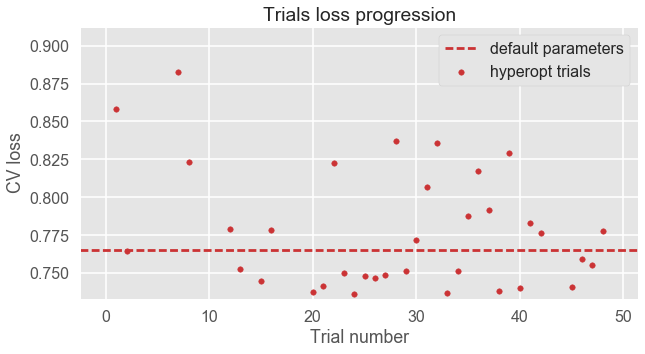

,params,num_iters,checks,total_loss,1_epoch_loss,2_epoch_loss,3_epoch_loss
0,"{'metric': 'multi_logloss', 'min_data_in_leaf'...",177,3,2.220537,0.737889,0.740323,0.742325
1,"{'metric': 'multi_logloss', 'min_data_in_leaf'...",133,3,2.226747,0.736060,0.741361,0.749326
2,"{'metric': 'multi_logloss', 'min_data_in_leaf'...",158,3,2.227923,0.736925,0.744172,0.746826
3,"{'metric': 'multi_logloss', 'min_data_in_leaf'...",143,3,2.235699,0.737659,0.745932,0.752108
4,"{'metric': 'multi_logloss', 'min_data_in_leaf'...",131,3,2.236337,0.739990,0.745975,0.750372


In [10]:
T.tune(trials_to_to=[50, 15, 5])
T.plot_1_epoch_results()
T.results.head()

In [11]:
import lightgbm as lgb
from sklearn.metrics import log_loss

model = lgb.train(
    T.results.sort_values('1_epoch_loss').iloc[0].params,
    lgb.Dataset(train, ytrain),
    num_boost_round=T.results.sort_values('1_epoch_loss').iloc[0].num_iters
)
print('Best model after first epoch on test:', log_loss(ytest, model.predict(test)))

model = lgb.train(
    T.results.iloc[0].params,
    lgb.Dataset(train, ytrain),
    num_boost_round=T.results.iloc[0].num_iters
)
print('Best model after all epochs on test:', log_loss(ytest, model.predict(test)))

print('\nBest parameters:')
print(T.results.iloc[0].params)
print('\nNumber of trees for these parameters:', T.results.iloc[0].num_iters)

Best model after first epoch on test: 0.70702609881
Best model after all epochs on test: 0.690246686964

Best parameters:
{'metric': 'multi_logloss', 'min_data_in_leaf': 0, 'verbose': 1, 'lambda_l1': 0.21028753805090483, 'objective': 'multiclass', 'feature_fraction': 0.8029208699445234, 'max_bin': 255, 'bagging_freq': 2, 'min_split_gain': 0.005651767160809951, 'lambda_l2': 4.444258922463265, 'num_class': 5, 'num_leaves': 412, 'bagging_fraction': 0.7766794589581006, 'learning_rate': 0.05}

Number of trees for these parameters: 177
